# Morpion Solitaire: random exploration

In this notebook we perform a random exploration of different variations of the game

In [ ]:
import torch
from MorpionSolitaire import *
from tqdm.notebook import trange
import ipywidgets as widgets

In [ ]:
from multiprocess import Pool
pool = Pool()

## Model

In [ ]:
net = torch.load('models/Descartes.pt')
net.eval()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
def count_moves(grids):
    with torch.no_grad():
        y = net(torch.tensor(grids).unsqueeze(1).float())
    return np.array(torch.round(5.0 * y / (1.0 - y)).squeeze())

## Cross

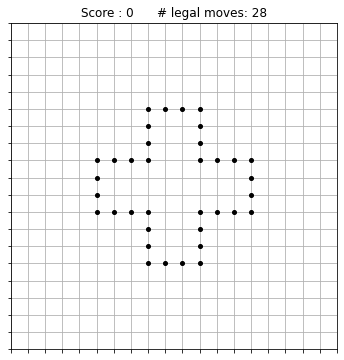

In [ ]:
game = NewGame()
game.print()

In [ ]:
len(game.moves)

28

In [ ]:
game.compute_weights(count_moves)

array([27., 27., 26., 26., 26., 27., 27., 26., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 26., 27., 27., 26., 26., 26.,
       27., 27.], dtype=float32)

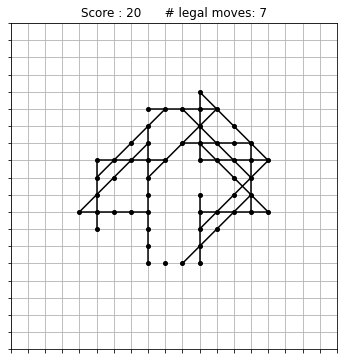

In [ ]:
game = game.play(17, depth = 20)
game.print()

In [ ]:
game.moves

[(13, 11, 1, 0),
 (13, 13, 4, 2),
 (18, 11, 1, 4),
 (16, 16, 4, 2),
 (18, 16, 4, 2),
 (19, 13, 2, 0),
 (19, 20, 2, 4)]

In [ ]:
game.compute_weights(count_moves)

array([ 5.,  6.,  5.,  9., 11.,  6.,  5.], dtype=float32)

**TO DO**:
- for a certain number of values of `t`, play in each case 1000 games (~10 minutes each)
- in each case keep track of the best game, the average, and the average of the best 500 games
- plot the distribution as a function of `t`, the goal being to find the optimal value of `t` (maybe implement bissection algorithm?)
- for the best value of `t`, play at least 10000 games and plot distribution

Also use multiprocessing

In [ ]:
scores = []
bestscore = 0
base = NewGame()
bestgame = base

In [ ]:
for _ in trange(1000):
    randomgame = base.play(model = count_moves, t = 3.0, copy_grid = True)
    scores.append(randomgame.score)
    if randomgame.score > bestscore:
        bestscore = randomgame.score
        bestgame = randomgame
max(scores)

83

Best game obtained:

In [ ]:
bestgame_steps = bestgame.games_list()

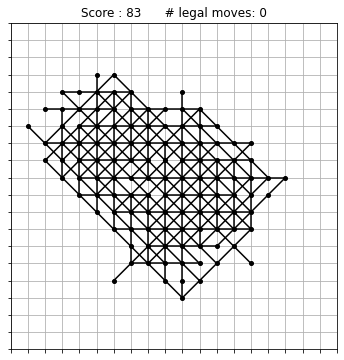

In [ ]:
bestgame.print()

In [ ]:
# bestgame.grid.print()
# plt.savefig('random_exploration_data/best_grid.png', bbox_inches='tight')

In [ ]:
# widgets.interact(lambda step, legal_moves: bestgame_steps[step].print(show_legal_moves = legal_moves), 
#                  step = widgets.IntSlider(min=0, max=bestscore, step=1, value=bestscore,
#                                           continuous_update=False),
#                  legal_moves = False);

Distribution of frequency for each score:

In [ ]:
frequency = np.histogram(scores, bins = bestscore + 1,
                         range = (-0.5, bestscore + 0.5))[0]
frequency = frequency/frequency.sum()

In [ ]:
random_frequency = np.load('random_exploration_data/rand_distribution.npy')

In [ ]:
random_frequency_x = np.array(range(random_frequency.size))
frequency_x = np.array(range(frequency.size))

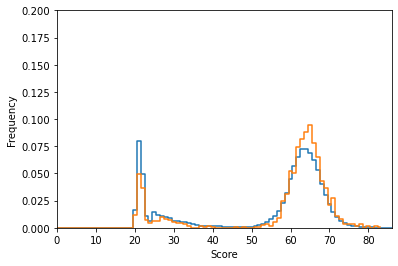

In [ ]:
plt.step(random_frequency_x, random_frequency, where='mid')
plt.step(frequency_x, frequency, where='mid')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(0, 86)
plt.ylim(0, 0.2)
# plt.savefig('random_exploration_data/distribution.png', bbox_inches='tight')
plt.show()

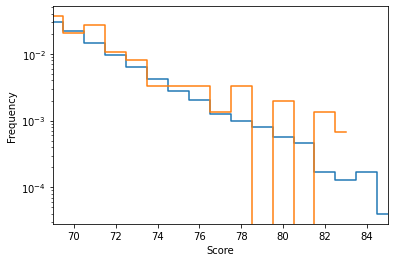

In [ ]:
plt.step(random_frequency_x[69:86], random_frequency[69:86], where='mid')
plt.step(frequency_x[69:86], frequency[69:86], where='mid')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(69, 85)
# plt.savefig('random_exploration_data/distribution_log.png', bbox_inches='tight')
plt.show()

This shows that despite simple rules, the dynamics of the game is very interesting: many random explorations end with a miserable score of about 20-25 points, but when the 40-points barrier is passed, they are again many more possible outputs, with a peak around 65 points. One also sees that it is in fact very hard to reach high scores from a purely random exploration.

In [ ]:
xyfit = np.polyfit(frequency_x[69:86], np.log(frequency[69:86]), 1)
xyfit[0], xyfit[1]

(-0.3798864821305689, 22.696620046911406)

In [ ]:
x0 = np.array([69,85])
y0 = np.exp(xyfit[0] * x0 + xyfit[1])

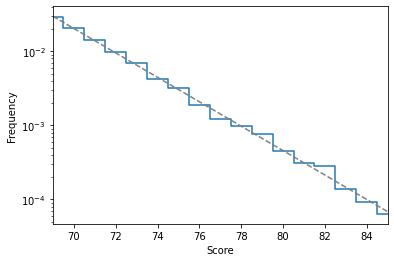

In [ ]:
plt.step(frequency_x[69:86], frequency[69:86], where='mid')
plt.plot(x0, y0, '--', color='grey')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(69, 85)
# plt.savefig('random_exploration_data/distribution_log.png', bbox_inches='tight')
plt.show()

This gives an estimate of how many games one needs to play to reach a given score:

In [ ]:
def required_n(goal):
    return np.round(1.0 / np.exp(xyfit[0] * goal + xyfit[1]))

In [ ]:
required_n(70), required_n(80), required_n(90), required_n(100)

(49.0, 2196.0, 98043.0, 4377674.0)

## Baseline model

In order to gauge how the AI is performing, we build a simple model that estimates how many points can still be added to a given grid based on the random data

In [ ]:
expdata = [np.array([x for x in scores if x >= i]).mean() - i for i in range(bestscore)]

In [ ]:
# np.save('random_exploration_data/rand_expectation.npy', expdata)

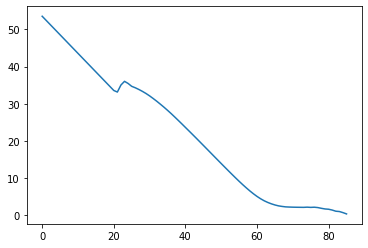

In [ ]:
plt.plot(expdata)
plt.show()

In [ ]:
def expectation(n):
    if n < len(expdata):
        return expdata[n]
    return 0

At the beginning of the game, you can expect to reach more than 50 points on average

In [ ]:
expectation(0)

53.56016363636363

Once you have reached a score of 40, you can expect to be able to add around 20 more points

In [ ]:
expectation(40)

23.610442306987203

Once you have reached a score of 70, you can only expect a few more points

In [ ]:
expectation(70)

2.115508771929825